# Orbit Emulator (Schwarzschild Photon Orbits)
## Hyperparameter sweep → selection → retraining (multi-seed) → physical validation

**Objetivo general.** Entrenar un emulador neuronal rápido para aproximar la dinámica de órbitas de fotones en la geometría de Schwarzschild, prediciendo la cantidad:
$$
u(\phi) \equiv \frac{R_S}{r(\phi)} \, ,
$$
de forma eficiente y con validación física (no sólo con una métrica de error promedio).

**Resumen del pipeline:**
1. Generación de dataset sintético de trayectorias y construcción de features (incluyendo Fourier features).
2. Sweep de hiperparámetros (59 experimentos, excluyendo smoke tests) comparando modos (`physical`, `filled`, etc.) y transformaciones del target (`none`, `log1p`).
3. Selección del mejor modelo con base en **test MSE** + validación física mediante gráficas $u(\phi)$ y órbitas $(x,y)$.
4. Re-entrenamiento del “winner” con múltiples seeds (150/151/152) para estimar estabilidad y variación estadística.
5. Reporte final: tablas, curvas de entrenamiento, y validación física en regímenes críticos/subcríticos/supercríticos.


## 1. Planteamiento físico: órbitas de fotones en Schwarzschild

En unidades geométricas, para una métrica de Schwarzschild (masa puntual), la dinámica radial puede escribirse en términos de:
$$
u(\phi)=\frac{R_S}{r(\phi)},
$$
donde $R_S$ es el radio de Schwarzschild. Para fotones (geodésicas nulas), la ecuación orbital típica toma la forma:
$$
\frac{d^2u}{d\phi^2} + u = \frac{3}{2}\,u^2 \quad \text{(forma estándar equivalente, según normalización)}.
$$
(La constante exacta depende de cómo se normalice $u$ con $R_S$.)

**Parámetro clave: el impacto $b$.** Existe un valor crítico:
$$
b_{\rm crit} = \frac{3\sqrt{3}}{2}\,R_S,
$$
que separa regímenes:
- **Subcrítico** ($b<b_{\rm crit}$): la trayectoria puede “caer” hacia el agujero negro (captura) dependiendo de condiciones iniciales.
- **Crítico** ($b=b_{\rm crit}$): aparece la esfera de fotones (photon sphere) y órbitas marginales.
- **Supercrítico** ($b>b_{\rm crit}$): típicamente trayectorias de dispersión.

En este trabajo, la red aprende un mapeo que aproxima:
$$
(\phi, u_0, b/b_{\rm crit}, \text{features de Fourier}) \mapsto u(\phi),
$$
para distintos regímenes, y luego convertimos $u(\phi)\rightarrow r(\phi)\rightarrow (x(\phi),y(\phi))$ para validación geométrica.


## 2. Representación de entrada: Fourier features (K=8) y significado

Para que un MLP capture variaciones periódicas/angulares en $\phi$ sin requerir una profundidad extrema, usamos un **embedding trigonométrico**:
$
\sin(k\phi), \cos(k\phi), \quad k=1,\dots,K.
$

Con $K=8$, agregamos $2K=16$ componentes de Fourier. Además incluimos variables “globales” constantes por trayectoria:
- $\phi$ (variable),
- $u_0$ (condición inicial),
- $b/b_{\rm crit}$ (controla el régimen dinámico).

Entonces el input típico es:
$
X(\phi)=\big[\phi,\; u_0,\; b/b_{\rm crit},\; \sin(\phi),\cos(\phi),\dots,\sin(8\phi),\cos(8\phi)\big].
$

**Nota:** En nuestros checkpoints aparece `in_dim = 20`. Eso significa que además de lo anterior (19 dimensiones si fueran sólo $\phi,u_0,b/b_c,2K$), se añadió **una feature extra** (por ejemplo un flag, normalización adicional, etc.). Esto se puede verificar leyendo la forma de la primera capa del modelo desde el checkpoint.

**¿Por qué K=8?** Es un compromiso:
- K pequeño: features insuficientes para capturar estructura fina en $u(\phi)$.
- K grande: el problema se vuelve más rígido y puede introducir oscilaciones/overfitting.
K=8 funcionó bien empíricamente en este sweep.


## 4. Modos de entrenamiento: `physical` vs `filled` (y por qué ganó `filled`)

En este problema, no todas las combinaciones $(b,u_0)$ generan una curva $u(\phi)$ "bien definida" o físicamente válida en todo el dominio (puede haber regiones inválidas o singularidades).

Por eso se probaron modos:

### 4.1 `physical`
Entrena directamente contra el target "físico" (la señal $u(\phi)$ tal cual), asumiendo que el dataset ya está completamente bien definido en el dominio.

**Riesgo:** si existen regiones inválidas o discontinuidades, el MLP puede aprender compromisos malos y aumentar el error.

### 4.2 `filled` (+ valid-flag)
En `filled`, se maneja explícitamente la invalidación:
- se “rellenan” valores inválidos con un `fill_value` (por ejemplo 0),
- y se añade un **flag de validez** (valid-flag) para que la red sepa qué puntos son reales vs relleno.

Esto suele estabilizar entrenamiento y evita que la red “persiga” valores imposibles.

**Resultado del sweep:** la familia ganadora fue:
$$
\texttt{filled} + \texttt{log1p} + \texttt{valid-flag}.
$$


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotx

plt.style.use(matplotx.styles.dracula)

ckpt_path = "../ckpt/best_re27_seed150.pt"

print("Epoch:", ckpt.get("epoch"))
print("Best val:", ckpt.get("best_val_loss"))



Epoch: 341
Best val: 0.0026082162455552155


In [2]:
import torch

ckpt_path = "../ckpt/best_re27_seed150.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("Keys in checkpoint:\n")
print(ckpt.keys())


Keys in checkpoint:

dict_keys(['model', 'optimizer', 'epoch', 'best_val_loss', 'train_hist', 'val_hist', 'lr_hist', 'lambda_pinn', 'init_lr', 'batch', 'seed', 'in_dim', 'width', 'depth', 'target_transform'])


## 3. Arquitectura del emulador: ¿qué significa width=320 y depth=5?

La red es un MLP con activación `tanh`. Sus hiperparámetros clave:
- **width**: número de neuronas por capa oculta.
- **depth**: número de capas ocultas.

Para el mejor modelo del sweep (exp_27):
- `width = 320`
- `depth = 5`

Eso corresponde a una arquitectura tipo:
$$
\mathbb{R}^{20}\rightarrow \mathbb{R}^{320}\rightarrow \mathbb{R}^{320}\rightarrow \mathbb{R}^{320}\rightarrow \mathbb{R}^{320}\rightarrow \mathbb{R}^{320}\rightarrow \mathbb{R}^{1}.
$$

**Intuición:**
- Más width/depth → mayor capacidad para aproximar funciones no lineales.
- Demasiada capacidad puede llevar a inestabilidad o sobreajuste.
El sweep mostró una zona óptima alrededor de width $\sim 320$ y depth moderada.


In [4]:
first_weight = ckpt["model"]["net.0.weight"]
in_dim = first_weight.shape[1]
width = first_weight.shape[0]

print("Input dim:", in_dim)
print("Width:", width)


Input dim: 20
Width: 320


In [5]:
import torch
import numpy as np

ckpt_path = "../ckpt/best_re27_seed150.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("=== CHECKPOINT SUMMARY ===")
print("epoch:", ckpt.get("epoch"))
print("best_val_loss:", ckpt.get("best_val_loss"))
print("seed:", ckpt.get("seed"))
print("lambda_pinn:", ckpt.get("lambda_pinn"))
print("init_lr:", ckpt.get("init_lr"))
print("batch:", ckpt.get("batch"))
print("in_dim:", ckpt.get("in_dim"))
print("width:", ckpt.get("width"))
print("depth:", ckpt.get("depth"))
print("target_transform:", ckpt.get("target_transform"))

print("\nCurves:")
print("train_hist len:", len(ckpt.get("train_hist", [])))
print("val_hist len:", len(ckpt.get("val_hist", [])))
print("lr_hist len:", len(ckpt.get("lr_hist", [])))


=== CHECKPOINT SUMMARY ===
epoch: 341
best_val_loss: 0.0026082162455552155
seed: 150
lambda_pinn: 1.3045209155976242e-06
init_lr: 0.0037541262000936
batch: 4096
in_dim: 20
width: 320
depth: 5
target_transform: log1p

Curves:
train_hist len: 341
val_hist len: 341
lr_hist len: 341


In [6]:
import torch.nn as nn

class OrbitMLP(nn.Module):
    def __init__(self, in_dim, width, depth):
        super().__init__()
        layers = []
        dims = [in_dim] + [width]*depth + [1]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = OrbitMLP(
    in_dim=int(ckpt["in_dim"]),
    width=int(ckpt["width"]),
    depth=int(ckpt["depth"]),
).to("cpu")

model.load_state_dict(ckpt["model"])
model.eval()

print("Model loaded OK ✅")


Model loaded OK ✅


## 5. Transformación del target: `log1p`

Se probó transformar el target para estabilizar el rango dinámico. En particular:
$$
y = \log(1+u).
$$

Esto:
- comprime valores grandes de $u$,
- reduce la sensibilidad a outliers,
- mejora estabilidad numérica.

Para interpretar predicciones en el espacio físico, debemos invertir:
$$
u = \exp(y) - 1.
$$

**Importante:** si no se aplica la inversa al predecir, la salida no está en unidades de $u$ y parecerá incorrecta.


In [8]:
def inverse_target_transform(y_pred, tf):
    # y_pred: numpy array
    if tf is None or tf == "none":
        return y_pred
    if tf == "log1p":
        return np.expm1(y_pred)
    raise ValueError(f"Unknown target_transform: {tf}")

@torch.no_grad()
def predict_u(model, X, target_transform="none"):
    Xt = torch.tensor(X, dtype=torch.float32)
    y = model(Xt).cpu().numpy().squeeze()
    u = inverse_target_transform(y, target_transform)
    return u


## 6. Función de pérdida: data loss + término PINN

Durante entrenamiento, además del error de datos (por ejemplo MSE entre predicción y target), se añade un término de regularización tipo PINN basado en un residual físico:
$$
\mathcal{L} = \mathcal{L}_{\rm data} + \lambda_{\rm PINN}\,\mathcal{L}_{\rm PINN}.
$$

Donde:
- $\mathcal{L}_{\rm data}$: MSE en el target (en el espacio transformado si aplica).
- $\mathcal{L}_{\rm PINN}$: penaliza que la predicción viole la ecuación diferencial aproximada (residual).
- $\lambda_{\rm PINN}$: peso del término físico.

**Observación del sweep:** en los experimentos realizados, $\lambda_{\rm PINN}$ nunca fue 0.
El mínimo observado fue $\sim 1.1\times 10^{-6}$. Por eso es razonable correr un experimento adicional con $\lambda_{\rm PINN}=0$ para cuantificar su contribución real.


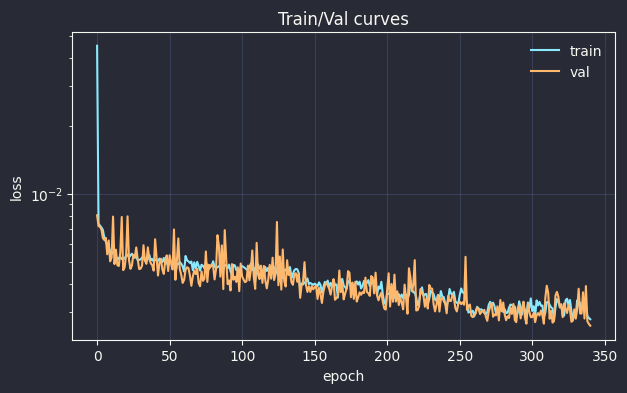

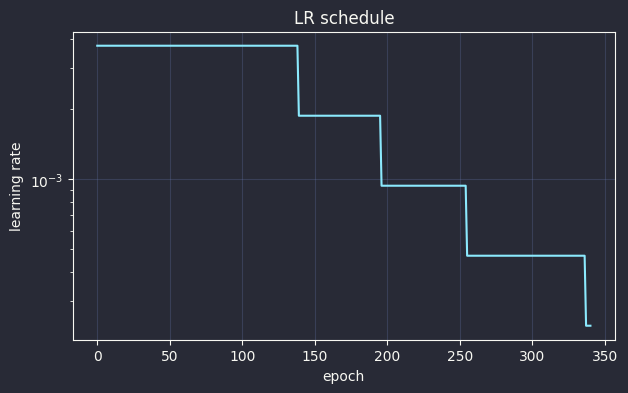

In [9]:
import matplotlib.pyplot as plt

train = np.array(ckpt["train_hist"], dtype=float)
val   = np.array(ckpt["val_hist"], dtype=float)
lr    = np.array(ckpt["lr_hist"], dtype=float)

plt.figure(figsize=(7,4))
plt.plot(train, label="train")
plt.plot(val, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train/Val curves")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(lr)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("LR schedule")
plt.grid(alpha=0.3)
plt.show()


## 7. Resultados del sweep (59 experimentos)

Tras excluir smoke tests:
- Total: **59** entrenamientos.
- Métrica primaria: **test MSE**.

**Comparación por modo:**
- filled + log1p: mejor desempeño promedio
- filled + none: intermedio
- physical + none: peor desempeño promedio (en esta configuración)

**Mejor modelo del sweep (exp_27):**
- mode: `filled`
- target_transform: `log1p`
- valid-flag: on
- width=320, depth=5
- batch=4096
- init_lr ≈ 3.754e-3
- weight_decay ≈ 1.42e-5
- λ_PINN ≈ 1.30e-6
- test MSE ≈ 2.68e-3

Además, se generaron gráficas físicas (u(phi) y órbitas XY) para verificar que el modelo no sólo minimize MSE sino que reproduce morfología de órbitas en distintos regímenes.


## 8. Retrain del winner (exp_27) con múltiples seeds

Para hacer el resultado más “reportable” (y estadísticamente sólido), se re-entrenó el mejor set de hiperparámetros usando seeds:
$$
\{150,151,152\}.
$$

**¿Por qué importa el seed?**
El seed controla:
- inicialización de pesos,
- orden del data-loader / shuffling,
- cualquier aleatoriedad en sampling.

Reportar resultados como:
$$
\text{mean} \pm \text{std}
$$
sobre seeds es una práctica estándar y fortalece la evidencia de que el resultado no es accidental.

**Mejor seed del retrain (según results.csv):**
- seed=150 con test MSE ≈ 2.598e-3


# 9. Evaluación local del mejor checkpoint

En esta sección cargamos el checkpoint `best_re27_seed150.pt`, reconstruimos la arquitectura **exacta** usando los metadatos guardados (in_dim, width, depth, target_transform), y preparamos funciones para predecir $u(\phi)$.

**Nota importante:** El checkpoint **NO** contiene `exp_id` como key (por eso tu `KeyError`).  
La identificación está en otras claves como `seed`, `epoch`, `target_transform`, y el nombre del archivo.


In [11]:
import torch
import numpy as np

ckpt_path = "../ckpt/best_re27_seed150.pt"  # TODO ajusta ruta
ckpt = torch.load(ckpt_path, map_location="cpu")

print("Keys:", ckpt.keys())
print("\n=== CHECKPOINT SUMMARY ===")
print("epoch:", ckpt.get("epoch"))
print("best_val_loss:", ckpt.get("best_val_loss"))
print("seed:", ckpt.get("seed"))
print("lambda_pinn:", ckpt.get("lambda_pinn"))
print("init_lr:", ckpt.get("init_lr"))
print("batch:", ckpt.get("batch"))
print("in_dim:", ckpt.get("in_dim"))
print("width:", ckpt.get("width"))
print("depth:", ckpt.get("depth"))
print("target_transform:", ckpt.get("target_transform"))


Keys: dict_keys(['model', 'optimizer', 'epoch', 'best_val_loss', 'train_hist', 'val_hist', 'lr_hist', 'lambda_pinn', 'init_lr', 'batch', 'seed', 'in_dim', 'width', 'depth', 'target_transform'])

=== CHECKPOINT SUMMARY ===
epoch: 341
best_val_loss: 0.0026082162455552155
seed: 150
lambda_pinn: 1.3045209155976242e-06
init_lr: 0.0037541262000936
batch: 4096
in_dim: 20
width: 320
depth: 5
target_transform: log1p


## 9.4 Curvas de entrenamiento y schedule de learning rate

Estas curvas ayudan a diagnosticar:
- sobreajuste (train ↓, val ↑),
- estancamiento,
- y el comportamiento del scheduler (ReduceLROnPlateau / etc.).


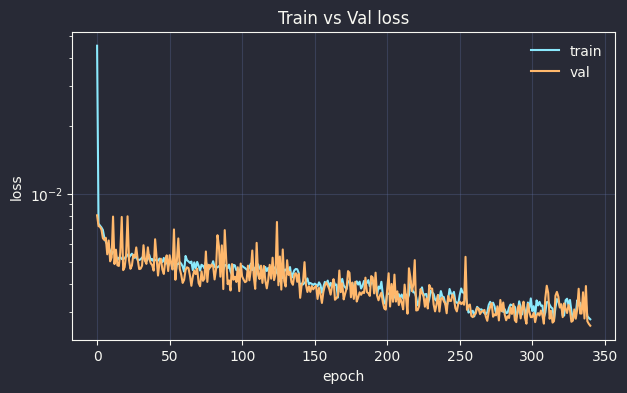

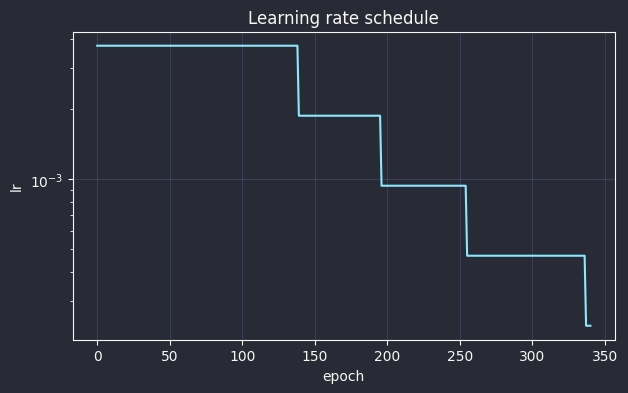

In [12]:
import matplotlib.pyplot as plt

train = np.array(ckpt["train_hist"], dtype=float)
val   = np.array(ckpt["val_hist"], dtype=float)
lr    = np.array(ckpt["lr_hist"], dtype=float)

plt.figure(figsize=(7,4))
plt.plot(train, label="train")
plt.plot(val, label="val")
plt.yscale("log")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("Train vs Val loss")
plt.grid(alpha=0.3); plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(lr)
plt.yscale("log")
plt.xlabel("epoch"); plt.ylabel("lr")
plt.title("Learning rate schedule")
plt.grid(alpha=0.3)
plt.show()


## 10. Resultados del retrain por seed (tabla y estadística)

Se reporta:
- el mejor seed (mínimo test MSE),
- y la estabilidad (mean ± std).


In [15]:
import pandas as pd

results_csv = "/tables/retrain_exp27_results.csv"  # TODO ajusta
df = pd.read_csv(results_csv).sort_values("test_mse")
display(df)

mu = df["test_mse"].mean()
sd = df["test_mse"].std(ddof=1)
print(f"test_mse: mean ± std = {mu:.6g} ± {sd:.3g}")
print("Best:", df.iloc[0][["exp_id","seed","test_mse","best_val"]].to_dict())


FileNotFoundError: [Errno 2] No such file or directory: '/tables/retrain_exp27_results.csv'

# 1. Ecuación de órbitas para fotones en Schwarzschild

Para un fotón en Schwarzschild (geodésica nula) es común trabajar con $u(\phi)=R_S/r(\phi)$.
La ecuación diferencial (en forma adimensional típica) que aparece en este pipeline es:

$$
u''(\phi) + u(\phi) - \frac{3}{2}\,u(\phi)^2 = 0,
$$

donde $ ' \equiv \frac{d}{d\phi} $.

En este proyecto:
- $R_S$ se fija (por defecto $R_S=1$) como escala.
- La clase de solución depende del parámetro de impacto $b$ relativo al valor crítico $b_{\rm crit}$.

$$
b_{\rm crit} = \frac{3\sqrt{3}}{2}\,R_S
$$

Esta separación genera **tres regímenes**:
- **Caso A:** $b=b_{\rm crit}$ (crítico; incluye la esfera de fotones).
- **Caso B:** $b<b_{\rm crit}$ (subcrítico; ramas incoming/outgoing).
- **Caso C:** $b>b_{\rm crit}$ (supercrítico; regiones scatter/inner).


# 2. Soluciones analíticas (A/B/C) como “ground truth”

El archivo `orbit_emulator.py` implementa una solución analítica **por piezas**:

- `_u_phi_crit` para el caso crítico $b=b_{\rm crit}$.
- `_u_phi_B` para el caso subcrítico $b<b_{\rm crit}$, usando funciones elípticas de Jacobi (cn).
- `_u_phi_C` para el caso supercrítico $b>b_{\rm crit}$, con raíces de un cúbico y Jacobi sn.

La función unificada:

```python
u_phi_general(phi, Rs, b, u0, phi0=0.0, branch=None, region=None)
